# Uploading libraries

In [2]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, ViTImageProcessor, ViTForImageClassification, ViTConfig, ResNetForImageClassification, ResNetConfig, BeitForImageClassification, BeitConfig, BeitImageProcessor, AutoFeatureExtractor
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model Recommendations
VGG-16: Despite being relatively deep, VGG-16 can still be effective on smaller datasets, especially when used with transfer learning. Its simplicity and well-understood architecture make it a good starting point.

ResNet-50: ResNet models, especially the shallower ones like ResNet-50, are known for their ability to avoid overfitting through the use of residual connections. This can be beneficial for learning from small datasets.

MobileNet: Designed for mobile and resource-constrained environments, MobileNets are lightweight and efficient, which can be advantageous when training data is limited.

SqueezeNet: This network achieves AlexNet-level accuracy with significantly fewer parameters. Its compact architecture makes it suitable for small datasets and limited computational resources.

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [3]:
# paths for data upload
FILE_PATH = "D:/data_for_DL_CV/"
TRAIN_FEATURES_PATH_0 = FILE_PATH + 'dead' 
TRAIN_FEATURES_PATH_1 = FILE_PATH + 'empty'
TRAIN_FEATURES_PATH_2 = FILE_PATH + 'keep0'
TRAIN_FEATURES_PATH_3 = FILE_PATH + 'keep1'
TRAIN_FEATURES_PATH_4 = FILE_PATH + 'keep2'
TRAIN_FEATURES_PATH_5 = FILE_PATH + 'reseed0'
TRAIN_FEATURES_PATH_6 = FILE_PATH + 'reseed1'
TRAIN_FEATURES_PATH_7 = FILE_PATH + 'split'

# list with pathe
PATHES_LIST = [TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2,TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5, TRAIN_FEATURES_PATH_6, TRAIN_FEATURES_PATH_7]

# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [4]:
labels = ['dead', 'empty', 'keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LIST):
    print(path)

D:/data_for_DL_CV/dead
D:/data_for_DL_CV/empty
D:/data_for_DL_CV/keep0
D:/data_for_DL_CV/keep1
D:/data_for_DL_CV/keep2
D:/data_for_DL_CV/reseed0
D:/data_for_DL_CV/reseed1
D:/data_for_DL_CV/split


In [5]:
class CustomImageDataset_train(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths
        self.img_labels = img_labels
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)

        self.original_len = len(self.img_sort)

    def __len__(self):
        return self.original_len * 8

    def __getitem__(self, idx):
        original_idx = idx % self.original_len
        augmentation_index = idx // self.original_len

        # Now, original_idx corresponds to the actual image index in your dataset
        img_path = self.img_sort[original_idx]
        try:
            image = read_image(img_path).float()
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[original_idx], dtype=torch.long)

        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            image = self.transform(image)

        image = self.augmentation(image, augmentation_index)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label
        
    def augmentation(self, image, augmentation_index):
        # Random horizontal flipping
        flip_type = augmentation_index % 2  # 0 for horizontal, 1 for vertical
        rotation = (augmentation_index // 2) * 90  # Will give 0, 90, 180, 270

        # Apply flip
        if flip_type == 0:
            image = TF.hflip(image)
        else:
            image = TF.vflip(image)

        # Apply rotation
        image = TF.rotate(image, rotation)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [6]:
class CustomImageDataset_test(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths   # List of image paths
        self.img_labels = img_labels # Corresponding labels for each image
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        self.len = len(self.img_sort)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        try:
            image = read_image(img_path).float()
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[idx], dtype=torch.long)

        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            image = self.transform(image)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

Training on fold 1/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.8384159253193781, Validation Loss: 2.0690181255340576, Accuracy: 20.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.45454545454545453
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.4113217775638287, Validation Loss: 2.559765338897705, Accuracy: 24.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.3571428571428571
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.0653060170320363, Validation Loss: 2.8710875511169434, Accuracy: 16.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.35294117647058826
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.13333333333333333
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 0.8412871590027442, Validation Loss: 2.1585235595703125, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Cla

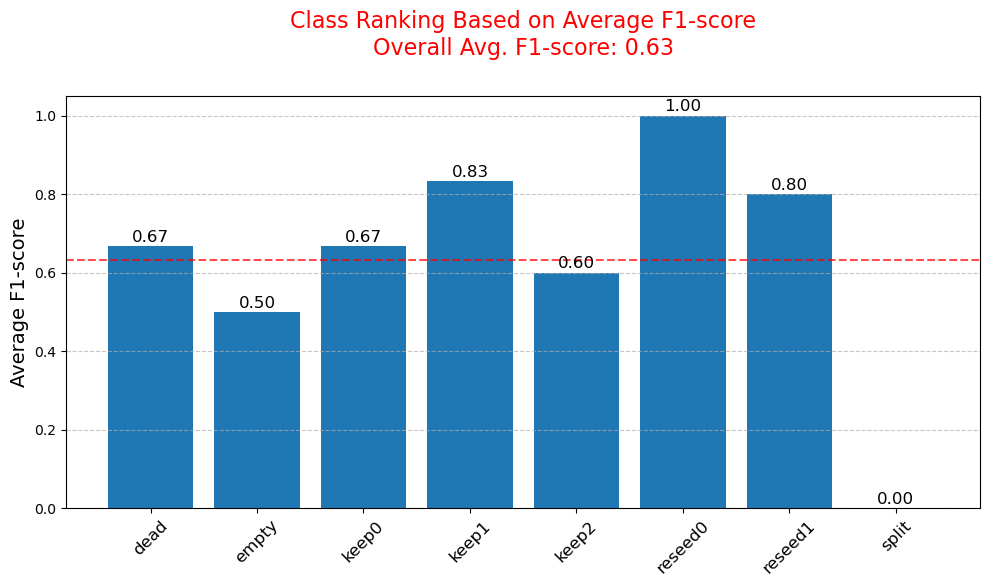

Training on fold 2/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.851398302958562, Validation Loss: 2.215014696121216, Accuracy: 16.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.2758620689655173
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.4136912272526667, Validation Loss: 2.5247745513916016, Accuracy: 20.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.3571428571428571
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.161152252784142, Validation Loss: 2.366379737854004, Accuracy: 36.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.4615384615384615
Class 2 F1 Score: 0.6
Class 3 F1 Score: 0.42857142857142855
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 0.9308351415854234, Validation Loss: 1.7009881734848022, Accuracy: 40.0 %
Class 0 F1 Score: 0.0
Class 1 

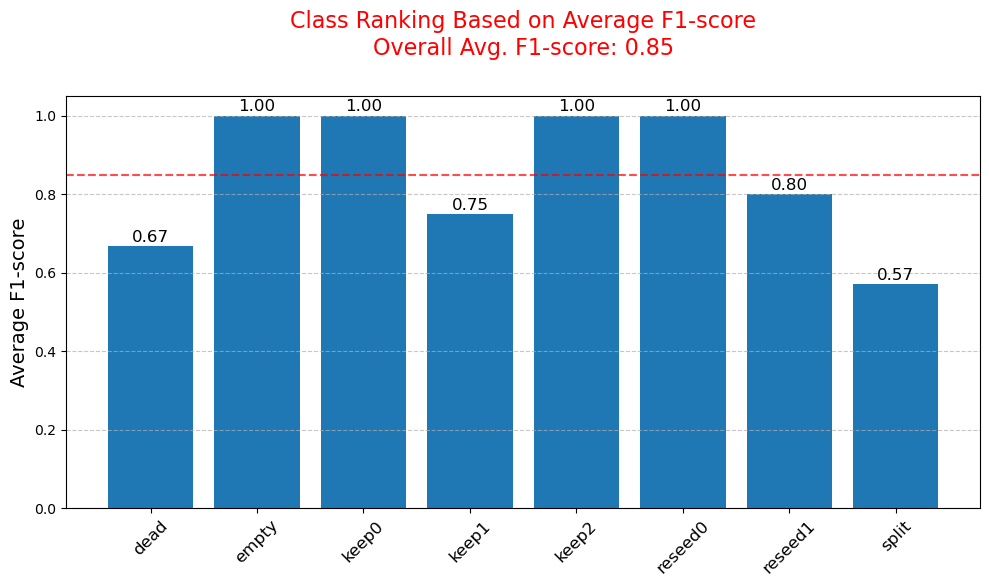

Training on fold 3/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.8245737827741182, Validation Loss: 2.141542673110962, Accuracy: 12.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.21428571428571425
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.3441220155129066, Validation Loss: 3.0452768802642822, Accuracy: 12.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.21428571428571425
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.0227527893506563, Validation Loss: 2.589905023574829, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.3157894736842105
Class 2 F1 Score: 0.6666666666666665
Class 3 F1 Score: 0.25
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.5
Epoch 4, Train Loss: 0.8394656502283536, Validation Loss: 1.6509038209915161, Accuracy: 48.0 %
Class 0 F1 Score: 0.0
Clas

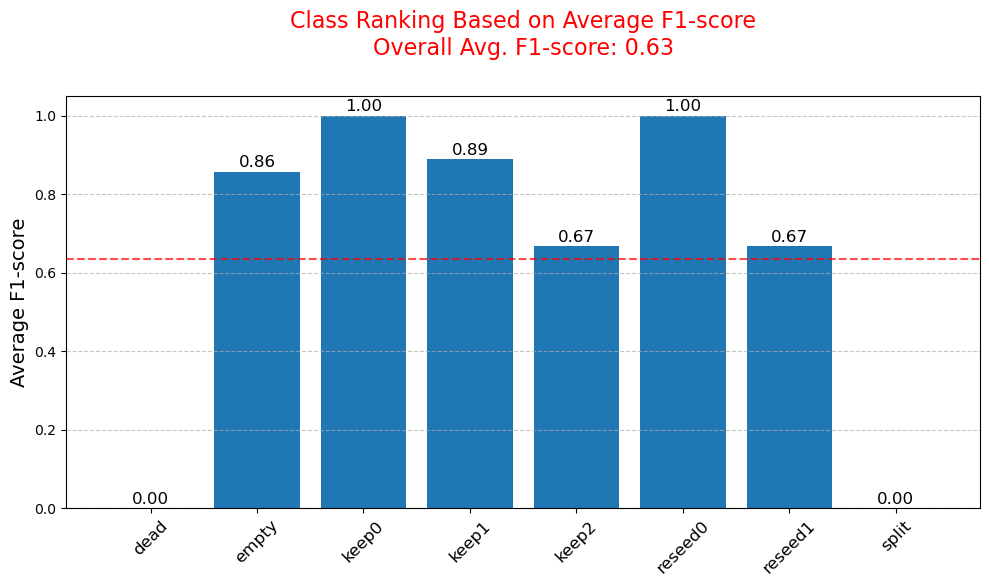

Training on fold 4/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.7796050676932702, Validation Loss: 2.1403255462646484, Accuracy: 20.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.28571428571428575
Class 2 F1 Score: 0.32
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.381439786690932, Validation Loss: 2.2057831287384033, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.28571428571428575
Class 2 F1 Score: 0.5714285714285715
Class 3 F1 Score: 0.5000000000000001
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.0699047217002282, Validation Loss: 2.058948516845703, Accuracy: 36.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.36363636363636365
Class 2 F1 Score: 0.7272727272727273
Class 3 F1 Score: 0.4
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 0.8075202107429504, Validation Loss: 1.154069423675537, Accuracy: 48.

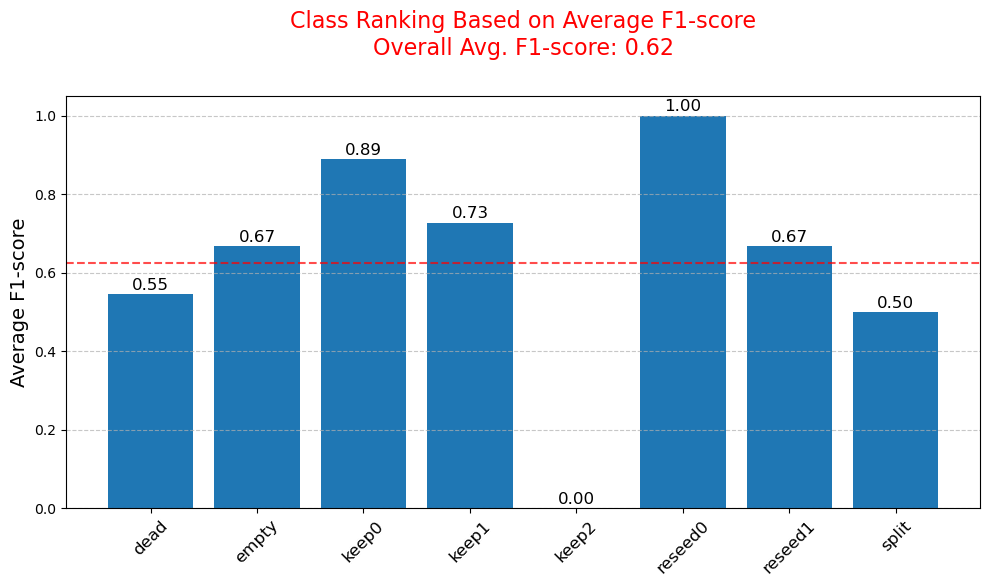

Training on fold 5/5


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.8133925107809215, Validation Loss: 2.0586965084075928, Accuracy: 29.166666666666668 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.36363636363636365
Class 3 F1 Score: 0.45454545454545453
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.3791722242648785, Validation Loss: 2.2864573001861572, Accuracy: 25.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.3333333333333333
Class 3 F1 Score: 0.3846153846153846
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.0355159594462469, Validation Loss: 2.3570375442504883, Accuracy: 20.833333333333332 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.35294117647058826
Class 2 F1 Score: 0.5714285714285715
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 0.7697419615892264, Validation Loss: 1.4

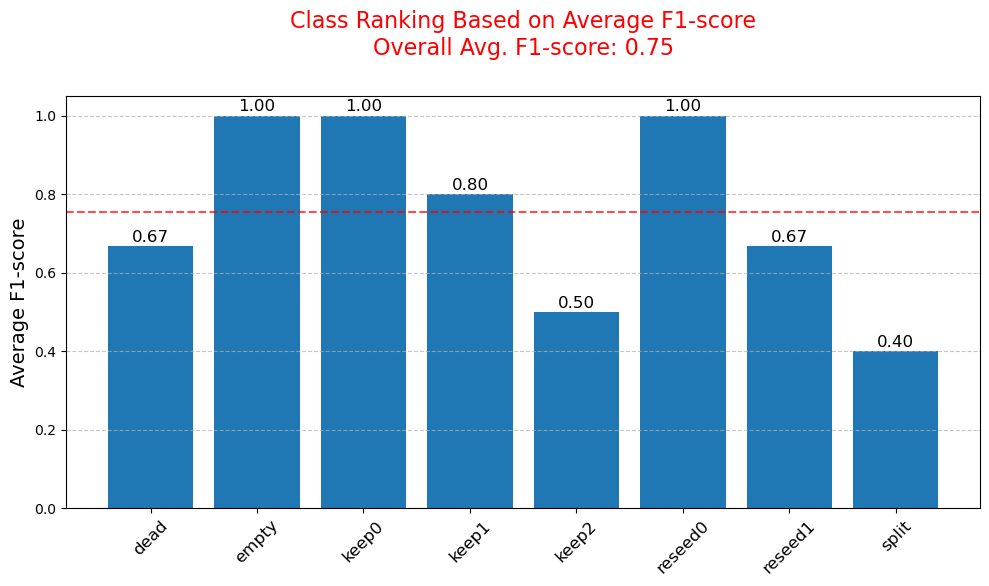

class_0_f1_score,▁▁███▆▆█▁█▆▆▆▆█▆▁▁▄▁▄▆▆▁▁▆▆▅▆▅▆▅▁█▄█▆▆█▆
class_1_f1_score,▅▄▅▇▅▇▅▅▁▇▇▇▇▇██▃▇▇▇▇▇▇▇▃█▇▇▆▇▇▇▁███████
class_2_f1_score,▁▅▆▆▇▇▆▆▁▇███▇▇█▁███████▅▇▇▇▇▇▇▇▃███████
class_3_f1_score,▄▄▆▆█▇▅▇▄▅▅▇▆▇▆▇▁▆▇█▆██▆▅▆▆▆▆▆▇▆▄▇▅▇▆▇▇▇
class_4_f1_score,▁▁▃▇▇▆▃▅▁▃▆▇▅▇▇▆▁▁▃▆▅▇█▆▁▃▆▄▄▆▆▆▁▅▄▅▆▅▃▅
class_5_f1_score,▁▁██████▁███████▁███████▁███████▁███████
class_6_f1_score,▁▁▇▇▇▇▇▆▁█▇███▇█▁▄▆▇▆██▇▁▁▇▆▇███▁▁▁█▆▆▁▆
class_7_f1_score,▁▁▁█▆▄█▁▁▄▅▅▅▆▆▅▁▃▄▃▃▅▇▅▁▇▅▃▇▄▇▄▁▃▃▅▅▄▃▄
epoch,▁▁▃▃▅▅▇▇▁▂▃▃▅▅▇▇▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█
final_accuracy,▂█▄▁▅
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████


Training on fold 1/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.5171120900374193, Validation Loss: 2.122856378555298, Accuracy: 24.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.37037037037037035
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 0.8350288592852079, Validation Loss: 2.864556312561035, Accuracy: 28.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.6666666666666666
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.45454545454545453
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 0.580162566441756, Validation Loss: 1.9381234645843506, Accuracy: 40.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.6666666666666666
Class 2 F1 Score: 0.4
Class 3 F1 Score: 0.47058823529411764
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.5714285714285715
Epoch 4, Train Loss: 0.4153870688034938, Validation Loss: 1.2183619737625122, Accuracy: 60.0

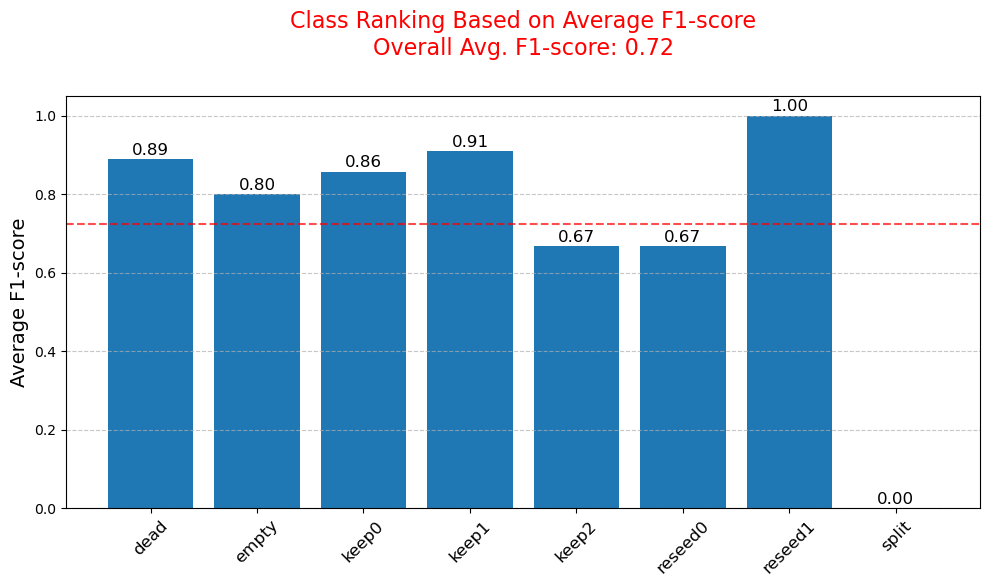

Training on fold 2/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.5938741060403676, Validation Loss: 2.0342857837677, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.7499999999999999
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.4347826086956522
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 0.9033931172811068, Validation Loss: 2.5807125568389893, Accuracy: 24.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.4615384615384615
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.3
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 0.5865278564966642, Validation Loss: 2.000694990158081, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.75
Class 3 F1 Score: 0.4210526315789473
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.3333333333333333
Epoch 4, Train Loss: 0.38784591738994306, Validation Loss: 1.3019672632217407, Accuracy: 48.0 %
Class 0 F1 Sco

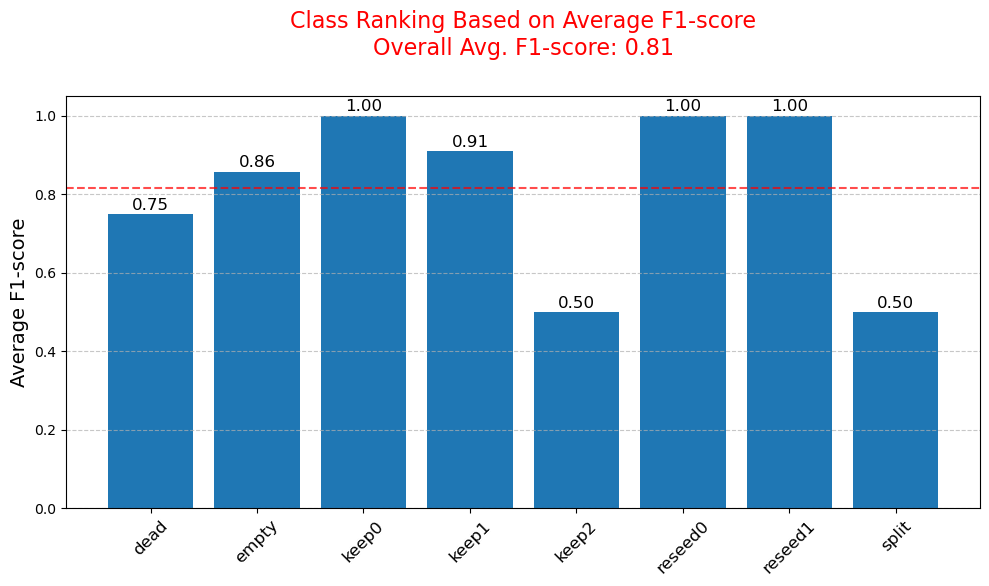

Training on fold 3/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.6111147495416493, Validation Loss: 2.622488021850586, Accuracy: 16.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.2758620689655173
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 0.8857624301543603, Validation Loss: 4.067931175231934, Accuracy: 16.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.2758620689655173
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 0.572308755837954, Validation Loss: 1.8693729639053345, Accuracy: 48.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.8000000000000002
Class 3 F1 Score: 0.4210526315789474
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.6666666666666666
Epoch 4, Train Loss: 0.38023630243081313, Validation Loss: 1.2202634811401367, Accuracy: 60.0 %
Class 0 F1 Sco

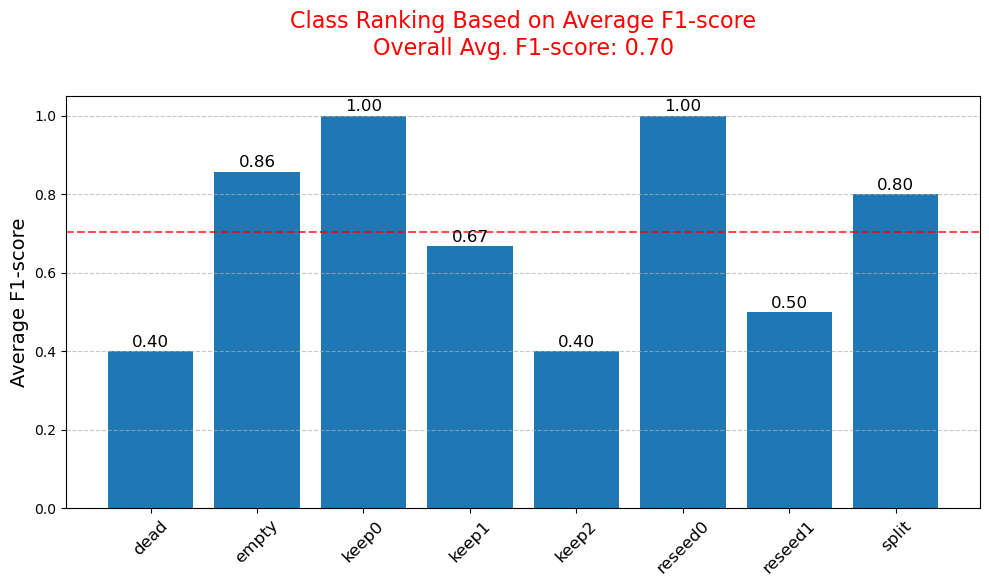

Training on fold 4/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.5255499344605665, Validation Loss: 2.587580680847168, Accuracy: 20.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.33333333333333337
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 0.8615924945244422, Validation Loss: 4.821142673492432, Accuracy: 20.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.33333333333333337
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 0.5358731769598447, Validation Loss: 3.749706983566284, Accuracy: 28.0 %
Class 0 F1 Score: 0.5
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.37037037037037035
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.4
Epoch 4, Train Loss: 0.3475942611694336, Validation Loss: 1.6619361639022827, Accuracy: 48.0 %
Class 0 F1 Score: 0.5
Class 1 F1 Score: 0.

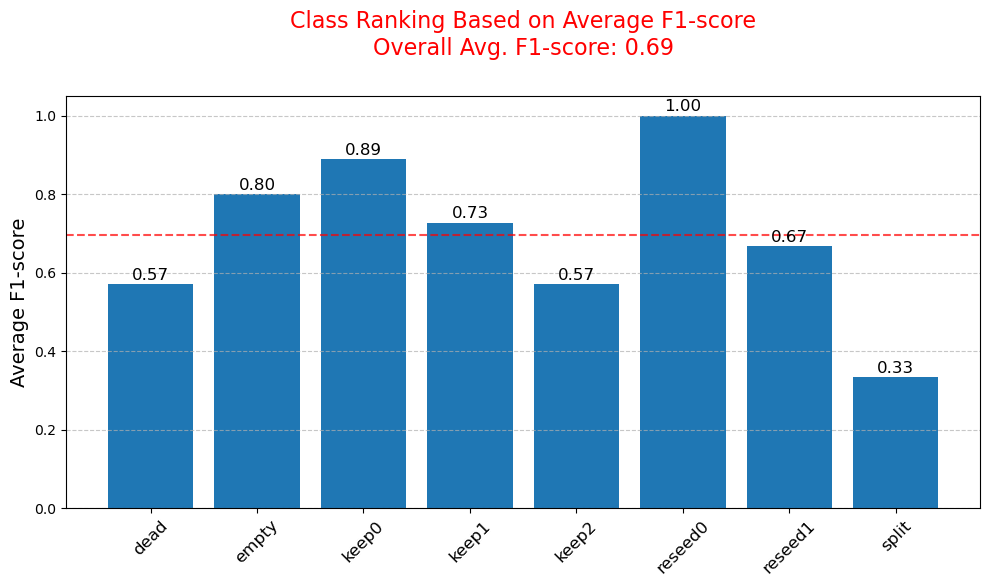

Training on fold 5/5


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.4789123901954064, Validation Loss: 2.1227588653564453, Accuracy: 29.166666666666668 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.37037037037037035
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 0.7776278990965623, Validation Loss: 2.4488327503204346, Accuracy: 33.333333333333336 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.7499999999999999
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.47619047619047616
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 0.5102511392189906, Validation Loss: 2.2149465084075928, Accuracy: 41.666666666666664 %
Class 0 F1 Score: 0.7499999999999999
Class 1 F1 Score: 0.3333333333333333
Class 2 F1 Score: 0.4
Class 3 F1 Score: 0.5263157894736842
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 0.3362012757704808, Validat

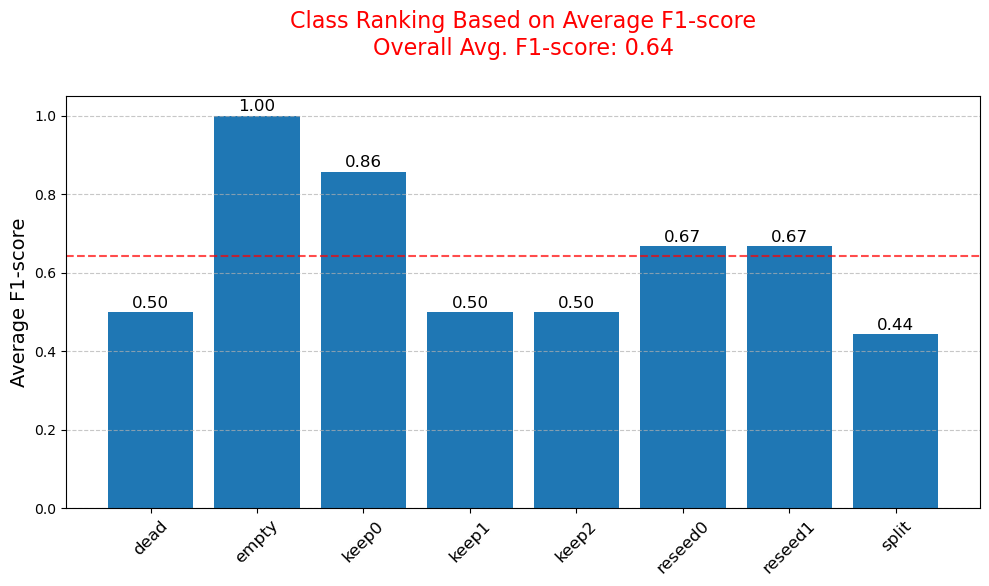

class_0_f1_score,▁█▇▇█▇▇▇▁▄▄▆▆▆▇▆▁▄▄▄▄▄▄▅▁▆▆▆▆▆▅▆▁▅▇▇▇▆▇▅
class_1_f1_score,▆▇▇▅▇▇▇▅▄▇▇▇▇▇▇▇▁▇▇▇▇▇▇▇▁▇▇▇▇▇▇▇▆▇█▇████
class_2_f1_score,▁▅▇▇▇▆▆▇▁███████▁███████▁▆▇▇▇▇▇▇▁██████▇
class_3_f1_score,▃▄▅▆▇▇▆▇▁███████▁█▇▆▇▇▇▇▂▅▅▅▄▄▅▅▃▇▆▅▅▆▆▃
class_4_f1_score,▁▁▄▆▆▇▆▇▁█▅█████▁█▆▇▆██▆▁▆▆▆▄▆▄▆▁▆▆▅▅▆▆▅
class_5_f1_score,▁▁▆▆▆▆▆▆▁█████▇█▁███████▁▆██████▁██████▆
class_6_f1_score,▁▁▆▆██▆█▁▇▆█▆▆▆▆▁▇▆▅▇▇▇▇▁▆▆▆▆██▆▁▆█▆███▆
class_7_f1_score,▁█▆▁▁▆▆▆▁▄▆▄▅█▁▅▁▆█▅▆███▁▄▄▆▄▄▄▄▁▄▆▄▆▄▆▅
epoch,▁▁▃▃▅▅▇▇▁▂▃▃▅▅▇▇▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█
final_accuracy,▇█▄▃▁
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.922547276203449, Validation Loss: 2.0518689155578613, Accuracy: 28.0 %
Class 0 F1 Score: 0.4
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.5333333333333333
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.15384615384615383
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.4682599306106567, Validation Loss: 1.8771458864212036, Accuracy: 40.0 %
Class 0 F1 Score: 0.4
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.5714285714285715
Class 3 F1 Score: 0.5
Class 4 F1 Score: 0.28571428571428575
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.3392847868112416, Validation Loss: 1.6398398876190186, Accuracy: 44.0 %
Class 0 F1 Score: 0.75
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.6
Class 3 F1 Score: 0.3076923076923077
Class 4 F1 Score: 0.25
Class 5 F1 Score: 1.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.180138661311223, Validation Loss: 1.4803906679153442, Accura

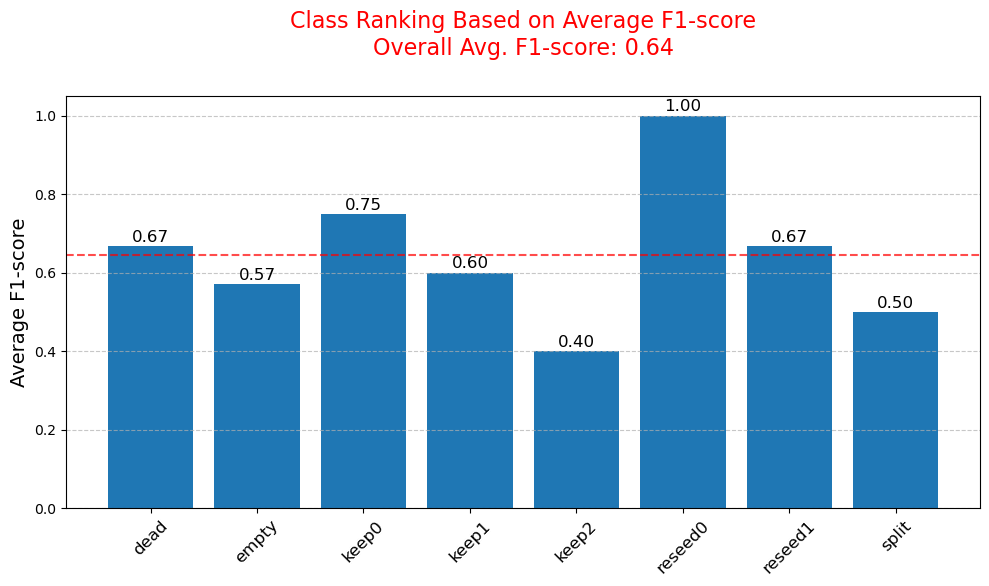

Training on fold 2/5
cuda
Epoch 1, Train Loss: 1.8967229953178992, Validation Loss: 1.4469726085662842, Accuracy: 52.0 %
Class 0 F1 Score: 0.6666666666666666
Class 1 F1 Score: 0.8571428571428571
Class 2 F1 Score: 0.5454545454545454
Class 3 F1 Score: 0.6
Class 4 F1 Score: 0.4
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.463736625818106, Validation Loss: 1.2914395332336426, Accuracy: 48.0 %
Class 0 F1 Score: 0.6666666666666666
Class 1 F1 Score: 0.8571428571428571
Class 2 F1 Score: 0.5
Class 3 F1 Score: 0.3333333333333333
Class 4 F1 Score: 0.5714285714285715
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.3778785650546734, Validation Loss: 1.4110697507858276, Accuracy: 52.0 %
Class 0 F1 Score: 0.36363636363636365
Class 1 F1 Score: 0.7499999999999999
Class 2 F1 Score: 0.5454545454545454
Class 3 F1 Score: 0.5714285714285715
Class 4 F1 Score: 0.8571428571428571
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Cla

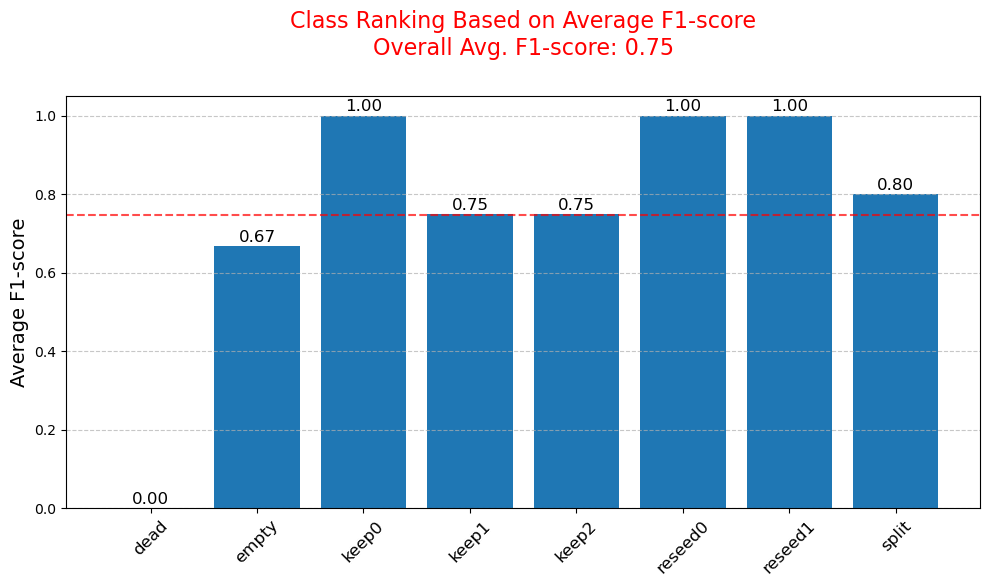

Training on fold 3/5
cuda
Epoch 1, Train Loss: 1.9051884779563317, Validation Loss: 1.4798591136932373, Accuracy: 44.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.7142857142857143
Class 3 F1 Score: 0.3529411764705882
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.451176785505735, Validation Loss: 1.339971661567688, Accuracy: 44.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.6666666666666666
Class 3 F1 Score: 0.28571428571428575
Class 4 F1 Score: 0.30769230769230765
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.316191526559683, Validation Loss: 1.2719658613204956, Accuracy: 44.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.6666666666666666
Class 3 F1 Score: 0.25
Class 4 F1 Score: 0.3333333333333333
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.28571428571428575
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.189184913268456, 

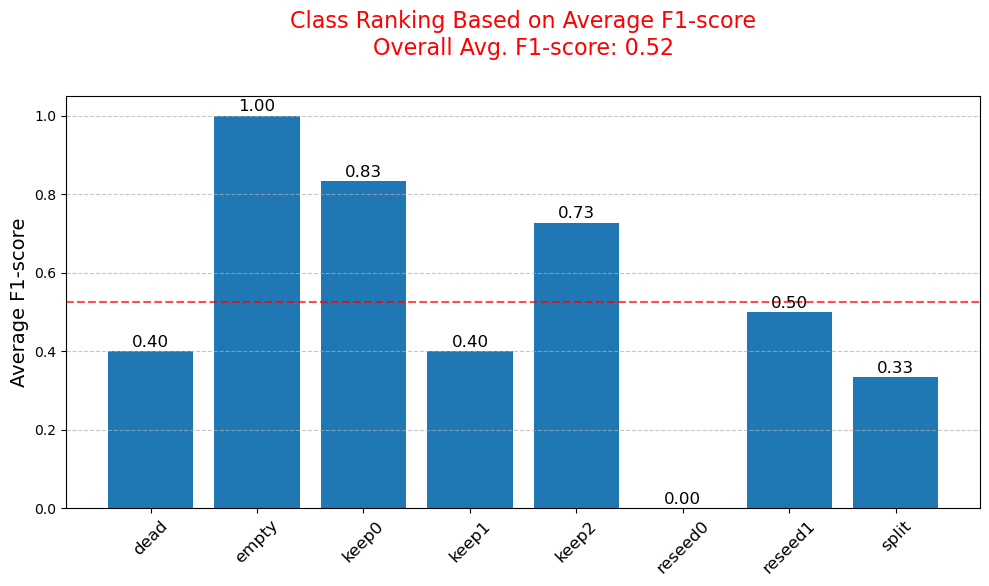

Training on fold 4/5
cuda
Epoch 1, Train Loss: 1.8795827535482554, Validation Loss: 1.7928601503372192, Accuracy: 40.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.6666666666666665
Class 3 F1 Score: 0.47619047619047616
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.4606127188755915, Validation Loss: 1.503145694732666, Accuracy: 36.0 %
Class 0 F1 Score: 0.4
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.6666666666666666
Class 3 F1 Score: 0.3076923076923077
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.2947545968569243, Validation Loss: 1.384283185005188, Accuracy: 60.0 %
Class 0 F1 Score: 0.5714285714285715
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.6666666666666665
Class 3 F1 Score: 0.7272727272727272
Class 4 F1 Score: 0.6666666666666666
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.1184019171274626, V

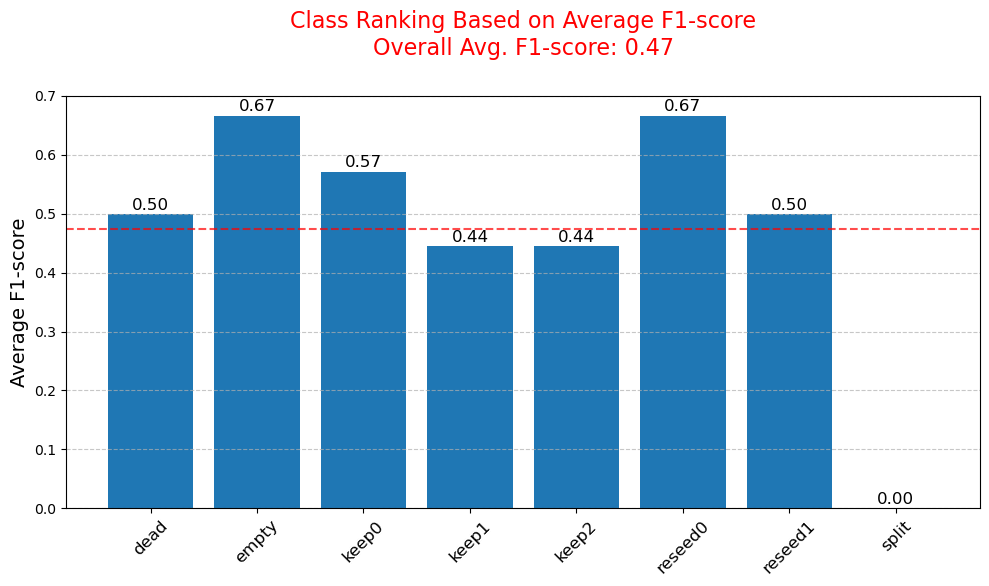

Training on fold 5/5
cuda
Epoch 1, Train Loss: 1.9429851770401, Validation Loss: 1.809745192527771, Accuracy: 37.5 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.4444444444444445
Class 3 F1 Score: 0.42857142857142855
Class 4 F1 Score: 0.4
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.4195596804985633, Validation Loss: 1.8326774835586548, Accuracy: 29.166666666666668 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.5
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.31578947368421056
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.2502736861889179, Validation Loss: 1.8454746007919312, Accuracy: 45.833333333333336 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5714285714285715
Class 2 F1 Score: 0.75
Class 3 F1 Score: 0.5333333333333333
Class 4 F1 Score: 0.3333333333333333
Class 5 F1 Score: 1.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.1421635242608876, Val

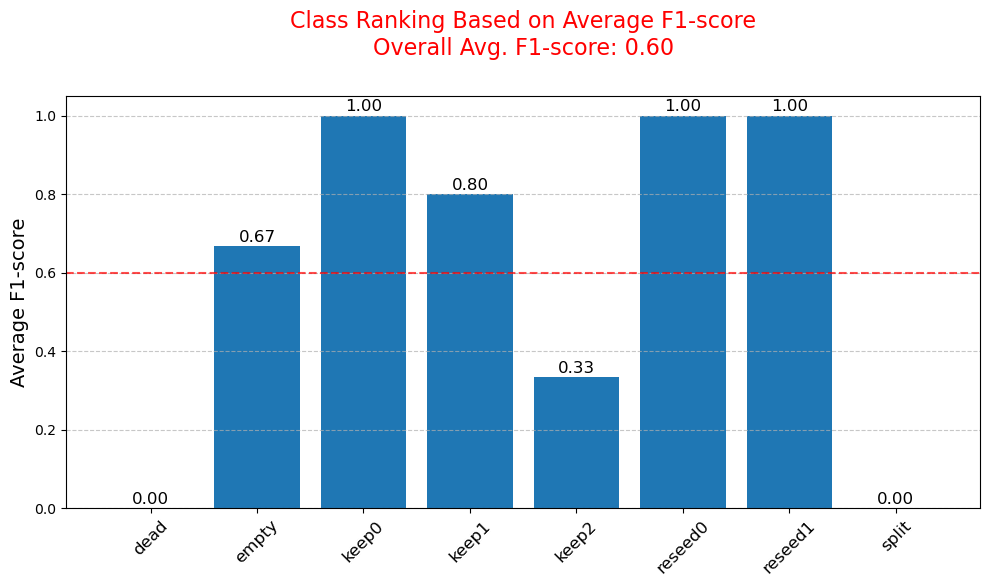

class_0_f1_score,▅█▅▅▆▅▇▅▇▅▅▅▅▄▄▁▁▆▅▅▅▅▅▅▅█▆▆▇▅▇█▁▁▃▆▄▅▅▁
class_1_f1_score,▂▂▂▂▂▁▂▁▆▆▅▆▅▅▅▄████████▆▆▆▆█▆▆▄▆▄▄▆▆▆▆▄
class_2_f1_score,▃▄▄▅▆▆▅▅▂▄▄██▅██▄▅█████▇▄▁▅▄▃▃▅▅▂▄██████
class_3_f1_score,▅▃▃▅▆▅▅▅▃▅▅█▇▆▇▇▃▅▆▆▇▇▆▆▃▅▆▆▆▄▄▄▁▁▄▄▅▆▅▇
class_4_f1_score,▃▁▃▃▅▃▁▁▆▇▆███▇█▄▄▃▅▆▆▆▃▁▆▅▅▆▅▃▅▄▄▁▃▃▃▃▄
class_5_f1_score,▁▁██████▁████▆██▁████▆▆▁▁▅█▆▆▆██▁▁██████
class_6_f1_score,▁▁▁▁▄█▇▇▁▅▆▇▇█▆█▁▅▆▅▅▅▅▄▁▃▆█▅▆▅▅▁▅▇▁████
class_7_f1_score,▁▁▁▇█▁█▁▁▁▁█▆███▁▁▁▁█▆▁▁▁█▁▁▇▁▆█▁▁▁▁▁▁▁▁
epoch,▁▁▃▃▅▅▇▇▁▂▃▃▅▅▇▇▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█
final_accuracy,▄█▅▁▄
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████


Training on fold 1/5
cuda
Epoch 1, Train Loss: 1.9251674963877752, Validation Loss: 2.2484703063964844, Accuracy: 28.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.4
Class 2 F1 Score: 0.4210526315789474
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.3333333333333333
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.615549087524414, Validation Loss: 2.0339066982269287, Accuracy: 36.0 %
Class 0 F1 Score: 0.6
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.5454545454545454
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.3333333333333333
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.3570416707258959, Validation Loss: 1.8170448541641235, Accuracy: 40.0 %
Class 0 F1 Score: 0.6666666666666666
Class 1 F1 Score: 0.5
Class 2 F1 Score: 0.6666666666666666
Class 3 F1 Score: 0.2857142857142857
Class 4 F1 Score: 0.22222222222222224
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.2398092655035167, 

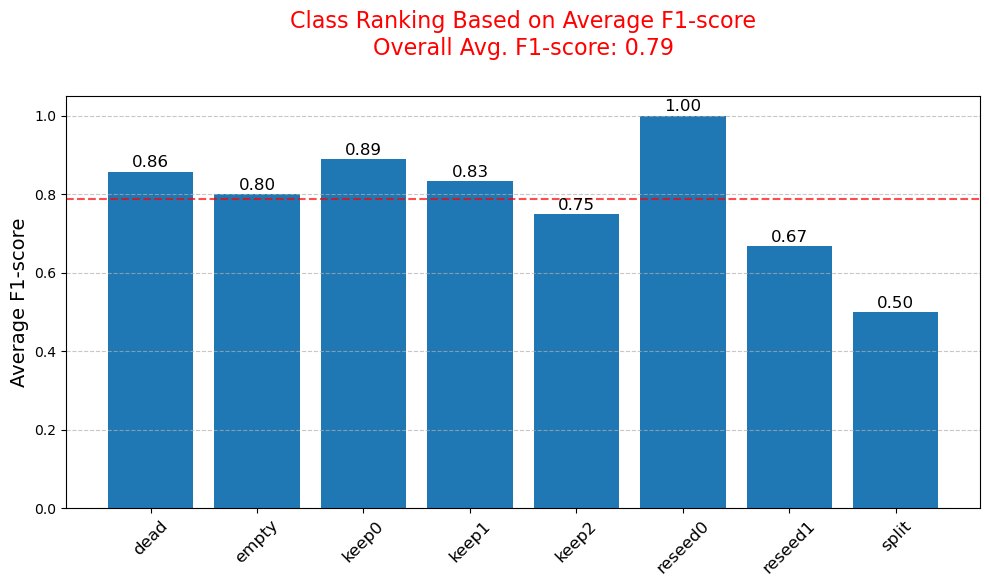

Training on fold 2/5
cuda
Epoch 1, Train Loss: 2.130945480786837, Validation Loss: 1.9137452840805054, Accuracy: 24.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.7499999999999999
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.2857142857142857
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.6669150040699885, Validation Loss: 1.4724125862121582, Accuracy: 40.0 %
Class 0 F1 Score: 0.4
Class 1 F1 Score: 0.8571428571428571
Class 2 F1 Score: 0.4444444444444445
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.5714285714285715
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.5146391208355243, Validation Loss: 1.517836570739746, Accuracy: 44.0 %
Class 0 F1 Score: 0.4
Class 1 F1 Score: 0.7499999999999999
Class 2 F1 Score: 0.6
Class 3 F1 Score: 0.4444444444444444
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.3697064931576068, Validation Loss: 

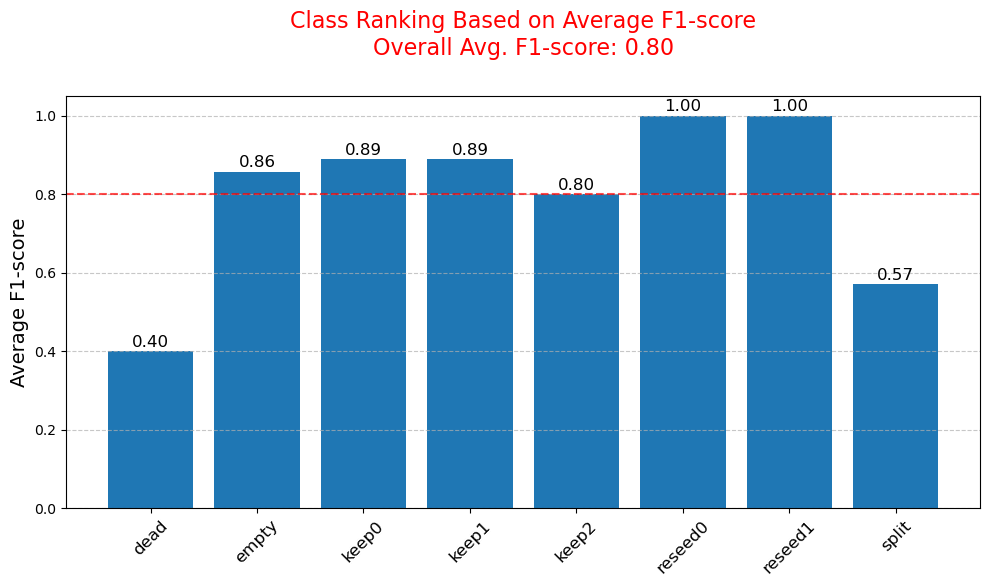

Training on fold 3/5
cuda
Epoch 1, Train Loss: 2.2147634487885695, Validation Loss: 1.6441422700881958, Accuracy: 40.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.4347826086956522
Class 3 F1 Score: 0.28571428571428575
Class 4 F1 Score: 0.4
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.7216885364972627, Validation Loss: 1.6261422634124756, Accuracy: 36.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.4347826086956522
Class 3 F1 Score: 0.25
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.6139858594307532, Validation Loss: 1.526902437210083, Accuracy: 48.0 %
Class 0 F1 Score: 0.5
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.5454545454545454
Class 3 F1 Score: 0.4285714285714285
Class 4 F1 Score: 0.4
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.5661615775181696, Validation Loss: 1.411552906036377, Accuracy

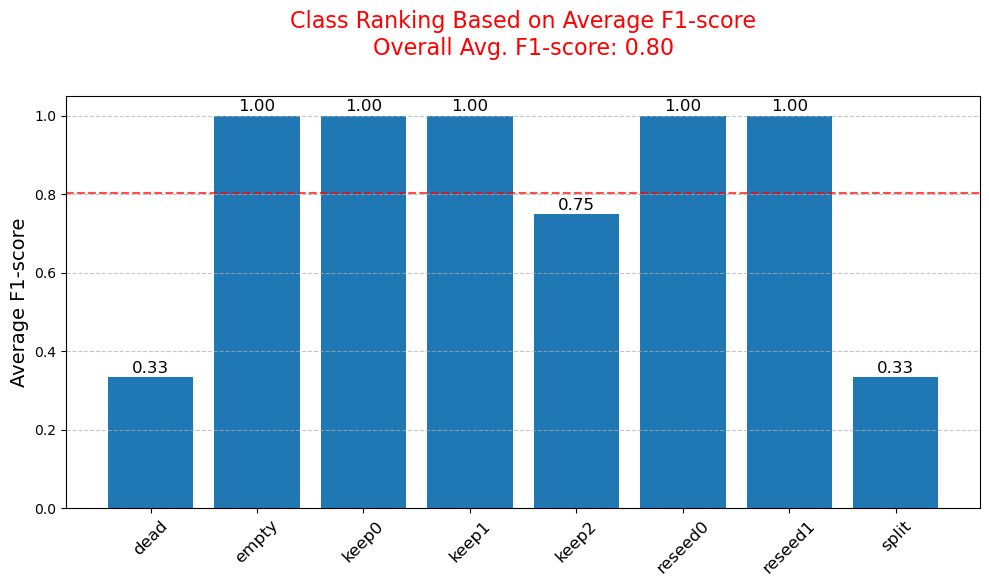

Training on fold 4/5
cuda
Epoch 1, Train Loss: 2.1336464423399706, Validation Loss: 1.8856475353240967, Accuracy: 36.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.6666666666666665
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.38095238095238093
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.613309465921842, Validation Loss: 1.7053842544555664, Accuracy: 32.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.5
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.25
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.25
Epoch 3, Train Loss: 1.4232326654287486, Validation Loss: 1.504065752029419, Accuracy: 52.0 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.7272727272727273
Class 3 F1 Score: 0.6
Class 4 F1 Score: 0.5333333333333333
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 4, Train Loss: 1.304387065080496, Validation Loss: 1.5498459339141846, Accuracy: 28.0 %
Class 

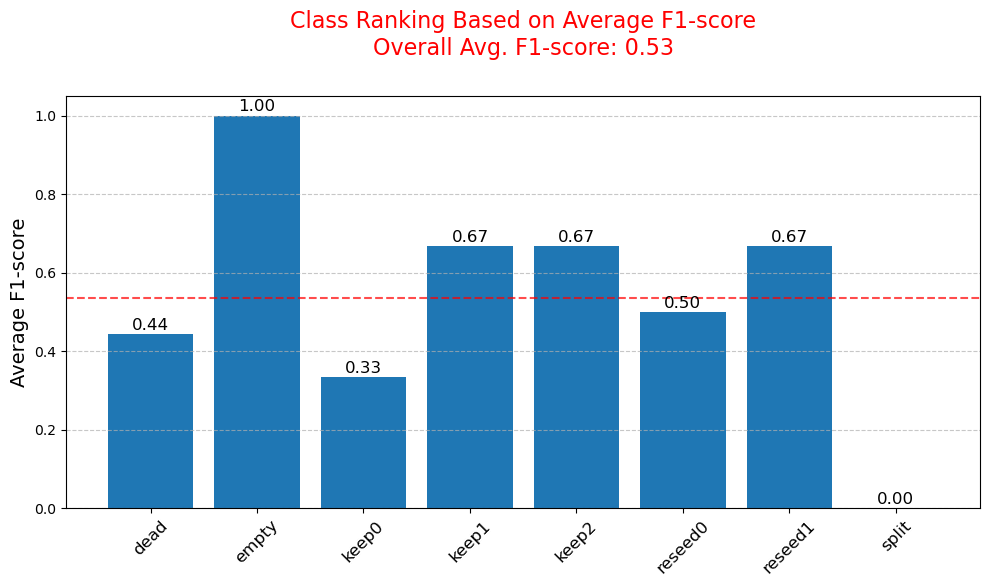

Training on fold 5/5
cuda
Epoch 1, Train Loss: 2.101771666453435, Validation Loss: 1.670493483543396, Accuracy: 33.333333333333336 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 1.0
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.3846153846153846
Class 4 F1 Score: 0.0
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 2, Train Loss: 1.6009463255222027, Validation Loss: 1.5334190130233765, Accuracy: 41.666666666666664 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.8
Class 2 F1 Score: 0.5
Class 3 F1 Score: 0.5714285714285715
Class 4 F1 Score: 0.4444444444444445
Class 5 F1 Score: 0.0
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
Epoch 3, Train Loss: 1.3359399758852446, Validation Loss: 1.6243504285812378, Accuracy: 45.833333333333336 %
Class 0 F1 Score: 0.0
Class 1 F1 Score: 0.5714285714285715
Class 2 F1 Score: 0.5714285714285715
Class 3 F1 Score: 0.5714285714285714
Class 4 F1 Score: 0.5714285714285715
Class 5 F1 Score: 0.6666666666666666
Class 6 F1 Score: 0.0
Class 7 F1 Score: 0.0
E

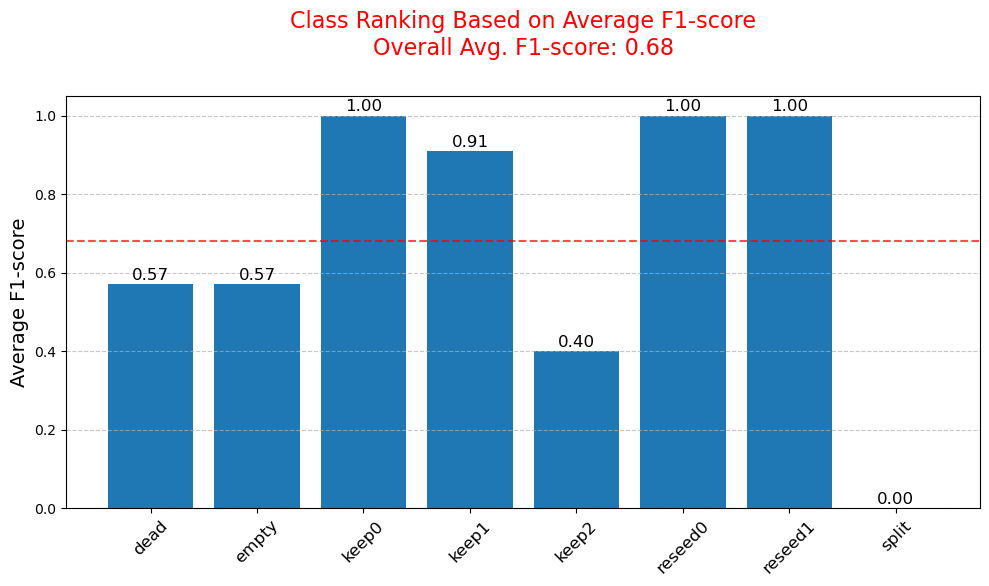

class_0_f1_score,▆▇▆▄█▄▆▆▄██▆▆▆▅▆▁▆▁▁▅▁▅▅▁▅▃▆▆▆▇▆▁▅▅▁▁▅▆▆
class_1_f1_score,▂▂▂▂▁▂▁▆▆▅▅▅▅▅▅▆███▆████▆▆▆█▆███▆▆▁▂▃▁▃▃
class_2_f1_score,▄▇▇▆▇▇▇▇▃▇▃▇▇▇█▇▂▁▇▆▇█▇▇▃▅▁▃▄▆▁▆▃▅█▇▇███
class_3_f1_score,▁▂▄▆▅▅▅▅▁▄▅▆▅▆▇▆▃▄▆▆▇▆▇█▁▅▅▄▁▅▄▅▅▅▇▇▆▇▇▇
class_4_f1_score,▄▃▃▅▅▅▆▄▆▁▇▅▇██▇▁▅▆▅▇▅▁▇▃▄▅▄▅▅▅▅▅▆█▅▅▇▇▅
class_5_f1_score,▁██████▆▁█▁█████▁▅█▆▁█▁▁▁▁▅▅▆█▁█▁▁█▁▆███
class_6_f1_score,▁▁▁▁▁▁▁▁▁▁▇▇██▆▇▁▁█▆▇▇▅▆▁▁▆▆▆▆▆▆▁▆▇▆████
class_7_f1_score,▁▁▄▁▇▅▇▁▁▁▁▅▅▇▅▅▁▁▃██▄▇█▃▁▁▁▁▁▄▄▁▁▁▁▄▁▁▁
epoch,▁▁▃▃▅▅▇▇▁▂▃▃▅▅▇▇▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█
final_accuracy,███▁▅
fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████


In [28]:
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv

model_names = ["microsoft/resnet-50", "microsoft/resnet-18", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]

for model_name in model_names:
    # Initialize a new wandb run
    wandb.init(project="organoid_classification", entity="laurent-gurtler")

    num_epochs = 30
    learning_rate = 5e-5
    batch_size = 64
    k_folds = 5
    weight_decay = 1e-5

    config = wandb.config
    config.learning_rate = learning_rate
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.k_folds = k_folds
    config.weight_decay = weight_decay


    all_labels_list = ['dead', 'empty', 'keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']

    all_fold_f1_scores = []
    num_labels = len(all_labels_list)  # The number of unique labels/classes in your dataset

    # Assuming PATHES_LIST contains paths to your different class directories
    img_labels = []
    img_sort = []
    for i, img_dir in enumerate(PATHES_LIST):
        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        img_labels.extend([i] * len(img_files))  # Labels for each image
        img_sort.extend([os.path.join(img_dir, f) for f in img_files])  # Paths for each image

    # Convert img_sort to a numpy array for easier indexing
    img_sort = np.array(img_sort)

    # Initialize StratifiedKFold
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert img_labels to numpy array for StratifiedKFold
    img_labels = np.array(img_labels)

    for fold, (train_idx, val_idx) in enumerate(kf.split(img_sort, img_labels)):
        print(f"Training on fold {fold+1}/{k_folds}")
        if "beit" in model_name:
            config = BeitConfig.from_pretrained(model_name, num_labels=num_labels)
            model = BeitForImageClassification(config)
        elif "resnet" in model_name:
            config = ResNetConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ResNetForImageClassification(config)
        elif "vit" in model_name:
            config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ViTForImageClassification(config)

                # Freeze all layers first
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze the last two layers (last block and the classifier)
        for param in model.resnet.layer4.parameters():
            param.requires_grad = True

        for param in model.classifier.parameters():
            param.requires_grad = True

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam([{'params': model.resnet.layer4.parameters()}, {'params': model.classifier.parameters()}], lr=learning_rate, weight_decay=weight_decay)

        # Split data into training and validation for this fold
        train_data = img_sort[train_idx]
        val_data = img_sort[val_idx]

        # Create datasets for this fold
        train_dataset = CustomImageDataset_train(train_data, img_labels[train_idx], 
                                                transform=False, 
                                                model_name=model_name)
        test_dataset = CustomImageDataset_test(val_data, img_labels[val_idx], 
                                            transform=False, 
                                            model_name=model_name)
        

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)

        wandb.watch(model, criterion, log="all", log_freq=10)

        epoch_f1_scores_dict_list = []

        num_images_displayed = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)  # Convert labels to torch.long
                optimizer.zero_grad()
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            wandb.log({"fold": fold+1, "epoch": epoch, "train_loss": running_loss/len(train_loader)})

            # Validation phase
            model.eval()
            all_labels = []
            all_predictions = []
            validation_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images).logits
                    predicted = outputs.argmax(dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                    # Move the labels and predictions to CPU for sklearn metrics
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())

            # Calculate accuracy and F1 score
            accuracy = 100 * correct / total
            f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
            # Check if the length of F1 scores matches the number of labels
            if len(f1_scores) != len(all_labels_list):
                print(f"Warning: Number of F1 scores ({len(f1_scores)}) does not match number of classes ({len(all_labels_list)})")
                # Trim the list of F1 scores to match the number of classes, if necessary
                f1_scores = f1_scores[:len(all_labels_list)]

            # Create a dictionary of class labels and their corresponding F1 scores
            f1_scores_dict = {all_labels_list[idx]: f1 for idx, f1 in enumerate(f1_scores)}
            epoch_f1_scores_dict_list.append(f1_scores_dict)

            # It might be useful to also get the classification report for all metrics
            classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

            # Logging the individual F1 scores
            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})


            wandb.log({"fold": fold+1, "epoch": epoch, "val_loss": validation_loss/len(test_loader), "val_accuracy": accuracy})

            # Print statistics for each class
            print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
                f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
            for idx, f1 in enumerate(f1_scores):
                print(f"Class {idx} F1 Score: {f1}")

            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})

        # Access the F1-scores for the last epoch
            # Access the F1-scores for the last epoch of this fold
        last_epoch_f1_scores = epoch_f1_scores_dict_list[-1]

        # Append model name, fold number, and F1 scores to the list
        fold_data = {"model_name": model_name, "fold": fold + 1}
        fold_data.update(last_epoch_f1_scores)
        all_fold_f1_scores.append(fold_data)

        # Clear the epoch_f1_scores_dict_list for the next fold
        epoch_f1_scores_dict_list.clear()

        # The last_epoch_f1_scores already contains the F1 scores for each class from the last epoch
        # Optionally, you can directly plot these scores if needed
        plot_average_f1_scores(all_labels_list, last_epoch_f1_scores)


        # After the loop, you may want to log the overall performance
        wandb.log({
            "fold": fold+1, "final_accuracy": accuracy,
            "fold": fold+1, "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
            "fold": fold+1, "final_classification_report": classification_rep
        })

        csv_filename = FILE_PATH + 'f1_scores_per_fold.csv'
        existing_data = []

        # Read existing data
        if os.path.exists(csv_filename):
            with open(csv_filename, 'r') as file:
                reader = csv.DictReader(file)
                existing_data = [row for row in reader]

        # Update or append new data
        for new_data in all_fold_f1_scores:
            model_found = False
            for existing_row in existing_data:
                if existing_row['model_name'] == new_data['model_name'] and existing_row['fold'] == str(new_data['fold']):
                    # Update existing row with new data
                    for key, value in new_data.items():
                        existing_row[key] = value
                    model_found = True
                    break
            if not model_found:
                # Convert numeric values to strings for CSV writing
                new_data_string = {k: str(v) for k, v in new_data.items()}
                existing_data.append(new_data_string)

        # Write updated data back to CSV
        header = ['model_name', 'fold'] + all_labels_list

        with open(csv_filename, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=header)
            writer.writeheader()
            for data_row in existing_data:
                writer.writerow(data_row)

    # Close the wandb run
    wandb.finish()


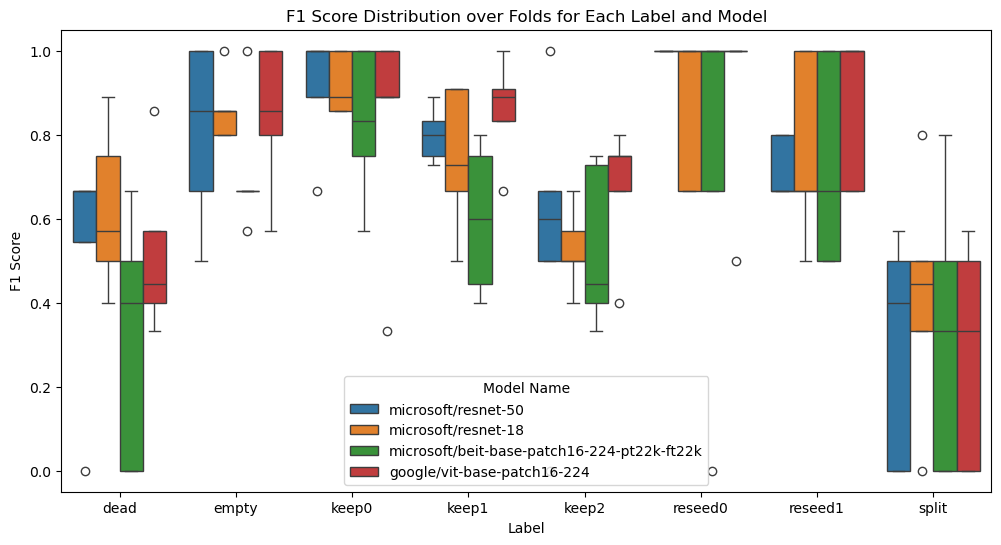

In [29]:
import seaborn as sns

df = pd.read_csv(csv_filename)
df_long = df.melt(id_vars=['model_name', 'fold'], 
                  value_vars=all_labels_list,  # list all your label columns here
                  var_name='label', value_name='f1_score')
# Creating a boxplot for each label within each model
plt.figure(figsize=(12, 6))

# You might need to adjust the size of the figure based on the number of models and labels
sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

plt.title('F1 Score Distribution over Folds for Each Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Model Name')
plt.show()